<a href="https://colab.research.google.com/github/rheopy/rheofit/blob/master/notebooks/example%20appmode/yield%20stress%20model%20selection%20file%20upload_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fit Flow curve
Notebook to create interactive app with function:
* Upload rheology xls file exported from trios with multitab option selected
* Alternatively 
* Execute Fit to flow curve data with model or models selected from a list

In [17]:
!pip install ipympl
!pip install git+https://github.com/rheopy/rheofit.git

  Cloning https://github.com/rheopy/rheofit.git to /tmp/pip-req-build-qbcdxwhi
  Running command git clone -q https://github.com/rheopy/rheofit.git /tmp/pip-req-build-qbcdxwhi
  Created wheel for rheofit: filename=rheofit-0.1.0-cp36-none-any.whl size=9874 sha256=5a7456791dac80fdcf86337bf9cc515f09d60bff6f1e095eedf031cc60e02b0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-mtnz1f6t/wheels/a4/58/61/22fb357c158d287fa7e6b6a2b1cc7379d68d1d40fdbb8daf64
Successfully built rheofit


In [22]:
%matplotlib inline
import ipympl
import sys
sys.path.append("./../../")
import os
import ipywidgets as widgets
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import rheofit
import lmfit

# Select and upload data file (currently 1 file only)

The assumed file format is xls file exported from trios with multitab option selected

In [23]:
import io

w = widgets.FileUpload(multiple=False)
w

FileUpload(value={}, description='Upload')

# Alternativly paste shear rate and stress columns

the two columns should be just numbers and have the same number of raws

In [24]:
Shear_rate_col=widgets.Textarea(description='Shear Rate Column [1/s]')
Stress_col=widgets.Textarea(description='Shear Stress Column [Pa]')

display(widgets.HBox([Shear_rate_col,Stress_col]))

# Select Rheological model from the list of available models

In [25]:
model_list=[rheofit.models.Bingham_model,
            rheofit.models.casson_model,
            rheofit.models.HB_model,
            rheofit.models.Powerlaw_model,
            rheofit.models.TC_model,
            rheofit.models.carreau_model,
            rheofit.models.carreau_model+rheofit.models.TC_model,
            rheofit.models.TCn_model,
            rheofit.models.carreau_model+rheofit.models.TCn_model,

           ]

for model in model_list:
    try:
        print(model.name)
        display(model.model_expression)
    except:
        pass

Model(Bingham, prefix='bingham_')


<IPython.core.display.Math object>

Model(casson, prefix='casson_')


<IPython.core.display.Math object>

Model(HB, prefix='HB_')


<IPython.core.display.Math object>

Model(Powerlaw, prefix='PL_')


<IPython.core.display.Math object>

Model(TC, prefix='TC_')


<IPython.core.display.Math object>

Model(carreau, prefix='carreau_')


<IPython.core.display.Math object>

(Model(carreau, prefix='carreau_') + Model(TC, prefix='TC_'))
Model(TCn, prefix='TCn_')


<IPython.core.display.Math object>

(Model(carreau, prefix='carreau_') + Model(TCn, prefix='TCn_'))


In [26]:
select_model_widget=widgets.Dropdown(options={item.name:item for item in model_list})
select_model_widget

Dropdown(options={"Model(Bingham, prefix='bingham_')": <lmfit.Model: Model(Bingham, prefix='bingham_')>, "Mode…

In [27]:
# Select data range and iterative mode

data_limit_widget_min=widgets.Text(description='data_min',value='0.0001')
data_limit_widget_max=widgets.Text(description='data_max',value='1000')

display(data_limit_widget_min)
display(data_limit_widget_max)

Text(value='0.0001', description='data_min')

Text(value='1000', description='data_max')

In [28]:
def make_par_widget(fit_function):
    if Shear_rate_col.value is not '':
        shear_rate=pd.Series([y for y in (x.strip() for x in Shear_rate_col.value.splitlines()) if y],name='Shear rate').astype(float)
        shear_stress=pd.Series([y for y in (x.strip() for x in Stress_col.value.splitlines()) if y],name='Stress').astype(float)
        rheodata=pd.concat([shear_rate, shear_stress], axis=1)
    else:
        datafile_object=pd.ExcelFile(io.BytesIO(w.value[list(w.value.keys())[0]]['content']))
        table_name_list = datafile_object.sheet_names
        rheodata=datafile_object.parse(table_name_list[-1],skiprows=1).drop(0).reset_index().astype('float')

    
    res_fit=select_model_widget.value.fit(rheodata['Stress'],x=rheodata['Shear rate'])
    
    model_name_widget=widgets.Text(description='Model name',value=res_fit.model.name,
                                   style={'description_width': 'initial'},
                                   layout=widgets.Layout(width='80%'))
    
    global iterate_wid
    iterate_wid=widgets.Checkbox(description='Iterative data range selection',
                                 value=False,
                                 style={'description_width': 'initial'},
                                 layout=widgets.Layout(width='80%'))
    
    global weight_widget
    weight_widget=widgets.Dropdown(description='Weight',options={'relative':None,'absolute':1},value=None,label='relative')

    
    par_list_wid=[]
    for param in res_fit.params:
        par_list_wid.append(widgets.HBox([widgets.Text(value=param),
                                          widgets.Text(description='min/val/max',value=str(res_fit.params[param].min)),
                                          widgets.Text(value=str(res_fit.params[param].value)),
                                          widgets.Text(value=str(res_fit.params[param].max)),
                                          widgets.Checkbox(description='fix',value=not(res_fit.params[param].vary))
                                         ]))
                      
    box_layout = widgets.Layout(display='flex',
                                flex_flow='column',
                                align_items='stretch',
                                border='solid')
    
    par_widgets=widgets.VBox([model_name_widget,iterate_wid,weight_widget]+par_list_wid,layout=box_layout)
    display(par_widgets)
    return par_widgets

def make_par_from_widget(par_widget):
    params = lmfit.Parameters()
    
    for par_info in par_widget.children[3:]:
        
        params.add(par_info.children[0].value,
                   min=float(par_info.children[1].value),
                   value=float(par_info.children[2].value),
                   max=float(par_info.children[3].value),
                   vary=not(par_info.children[4].value)
                   )

    return params

In [29]:
parameter_display_widget=widgets.Output()

@parameter_display_widget.capture()
def prepare_analysis(sender):
    clear_output()
    model=select_model_widget.value
    global par_wid
    par_wid=make_par_widget(model)

prepare_analysis_button=widgets.Button(description='Prepare Analysis')
prepare_analysis_button.on_click(prepare_analysis)
display(prepare_analysis_button)

Button(description='Prepare Analysis', style=ButtonStyle())

In [30]:
display(parameter_display_widget)

Output()

In [14]:
Out=widgets.Output()

@Out.capture()
def execute_analysis(sender):
    figlist=plt.get_fignums()
    
    for i in figlist:
        plt.close(i)
    
    if Shear_rate_col.value is not '':
        shear_rate=pd.Series([y for y in (x.strip() for x in Shear_rate_col.value.splitlines()) if y],name='Shear rate').astype(float)
        shear_stress=pd.Series([y for y in (x.strip() for x in Stress_col.value.splitlines()) if y],name='Stress').astype(float)
        rheodata=pd.concat([shear_rate, shear_stress], axis=1)

    else:
        datafile_object=pd.ExcelFile(io.BytesIO(w.value[list(w.value.keys())[0]]['content']))
        table_name_list = datafile_object.sheet_names
        rheodata=datafile_object.parse(table_name_list[-1],skiprows=1).drop(0).reset_index().astype('float')

    
    condition=(rheodata['Shear rate']>float(data_limit_widget_min.value)) & (rheodata['Shear rate']<float(data_limit_widget_max.value))
    
    data=rheodata[condition]
    
    weights=1/data['Stress']
    
    if weight_widget.value == 1:
        weights=data['Stress']**0
    
    model=select_model_widget.value
    params=make_par_from_widget(par_wid)
    
    global fit
    if iterate_wid.value is True:
        iterate=True
        while iterate:
            data=rheodata[condition]
            
            weights=1/data['Stress']
    
            if weight_widget.value == 1:
                weights=data['Stress']**0
            
            fit=model.fit(data['Stress'],x=data['Shear rate'], weights=weights, params=params)
            if min(data['Shear rate'])<fit.params['TC_gammadot_crit'].value:
                condition=(rheodata['Shear rate']>float(data_limit_widget_min.value)) & (rheodata['Shear rate']<float(data_limit_widget_max.value)) & (rheodata['Shear rate']>fit.params['TC_gammadot_crit'].value)
            else:
                iterate=False
    
    else:
        fit=model.fit(data['Stress'],x=data['Shear rate'], weights=weights, params=params)
   
    res_table=rheofit.models.show_parameter_table(fit)
    
    display(res_table)
    display(fit)
    
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    ax.plot(data['Shear rate'],data['Stress'],'o',label='Analized data')
    ax.plot(rheodata['Shear rate'],rheodata['Stress'],'o',label='Available data',mfc='none')

    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.plot(rheodata['Shear rate'],fit.eval(x=rheodata['Shear rate']), label='Best fit')
    ax.set_xlabel('Shear rate [1/s]')
    ax.set_ylabel('Stress [Pa]')
    fig.show()

exec_analysis_button=widgets.Button(description='Execute Analysis')
exec_analysis_button.on_click(execute_analysis)

@Out.capture()
def clear_analysis(object):
    figlist=plt.get_fignums()
    
    for i in figlist:
        plt.close(i)
        
    clear_output()

clear_analysis_button=widgets.Button(description='Clear Analysis')
clear_analysis_button.on_click(clear_analysis)


Button(description='Execute Analysis', style=ButtonStyle())

Button(description='Clear Analysis', style=ButtonStyle())

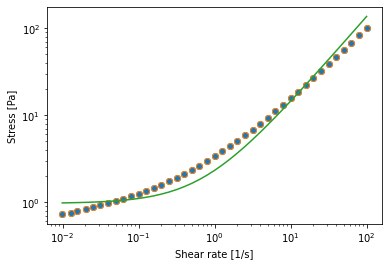

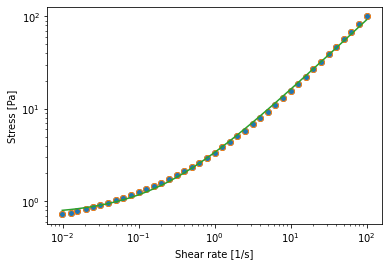

In [15]:
display(exec_analysis_button)
display(clear_analysis_button)

In [21]:
display(Out)

Output()